<a href="https://colab.research.google.com/github/kks0507/AI_Image_Search_Engine/blob/main/AI_Image_Search_Engine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI 이미지 검색 엔진


## Chroma DB 활용

### 1단계. 라이브러리 가지고 오기

In [ ]:
!pip install -q chromadb transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 5.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 599.2/599.2 kB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 273.8/273.8 kB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.6/94.6 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 78.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.9/88.9 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install transformers

### 2단계. 데이터 셋 가지고 오기

In [ ]:
!wget -q https://github.com/kairess/toy-datasets/raw/master/Food-11.zip
!unzip -q Food-11.zip

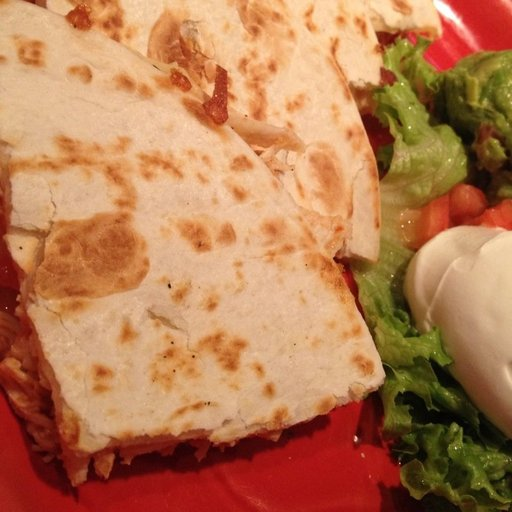

In [ ]:
# PIL 라이브러리 활용 압축을 푼 데이터 셋의 이미지 미리보기 (테스트 이미지)
from PIL import Image

img = Image.open("test/Bread/0.jpg")

img

### 3단계. 이미지 모델을 임베딩 하기

#### 3-1) 허깅페이스에서 facebook의 비전 트랜스포머 모델인 DINO를 활용한다.


In [ ]:
# 모델을 로드한다.
from transformers import ViTFeatureExtractor, ViTModel

feature_extractor = ViTFeatureExtractor.from_pretrained('facebook/dino-vits16')
# 모델을 CUDA 지원 GPU로 이동시켜 GPU의 빠른 연산 능력을 활용
model = ViTModel.from_pretrained('facebook/dino-vits16').to("cuda")

print("Models loaded!")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/244 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/453 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/86.7M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vits16 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Models loaded!


#### 3-2) 테스트 이미지를 임베딩 한다.

In [ ]:
# 생성된 임베딩 값 반환
img_tensor = feature_extractor(images=img, return_tensors="pt").to("cuda")

# 모델에 img_tensor를 입력하여 출력값을 얻음
outputs = model(**img_tensor)

# 모델의 pooler_output을 추출하여 텐서에서 분리(detach)하고,
# 이를 CPU로 이동시킨 후 넘파이 배열로 변환, 마지막으로 1차원 벡터로 만듦
embedding = outputs.pooler_output.detach().cpu().numpy().squeeze()

# 생성된 임베딩 값 반환
embedding

array([-7.18212724e-01, -7.60091320e-02,  9.99174297e-01,  9.66691077e-01,
       -2.22567737e-01, -9.19247985e-01,  6.76012874e-01,  4.99497473e-01,
        1.22598939e-01,  9.99309123e-01,  9.48012948e-01,  9.99247015e-01,
       -7.94635177e-01, -1.09631509e-01, -9.44475114e-01,  9.27111983e-01,
       -8.64456058e-01,  9.19185758e-01, -9.56393600e-01,  4.65816557e-01,
        2.31824413e-01, -9.92554724e-01, -8.21849525e-01, -8.79749715e-01,
       -9.96003747e-01,  9.68141332e-02, -7.40118742e-01, -9.89365697e-01,
        5.28286874e-01,  9.37499046e-01,  2.90041417e-01, -4.23334897e-01,
       -2.15789512e-01,  3.08593839e-01, -9.96611655e-01, -9.23670053e-01,
        8.86642575e-01, -9.86926258e-01, -9.23033059e-01,  4.15706575e-01,
       -7.87402391e-01, -9.99947906e-01, -9.44349170e-02,  5.76513886e-01,
        3.76247615e-01,  4.53246981e-01, -9.94169652e-01, -1.51894897e-01,
        9.98107314e-01,  7.58508027e-01, -5.73152065e-01, -9.94107664e-01,
       -3.25780571e-01, -

In [ ]:
embedding.shape

(384,)

### 4단계. Chroma DB 활용 (https://www.trychroma.com/) 참고

In [ ]:
!pip install chromadb

In [ ]:
import chromadb

client = chromadb.Client()

# food라는 테이블을 생성 (SQL 개념으로 접근 시)
collection = client.create_collection("foods")

### 5단계. 모든 이미지 벡터화하기

#### 5-1) 모든 이미지 불러오기

In [ ]:
from glob import glob  # glob 모듈을 사용하여 파일 경로를 찾음

# "test" 폴더 하위의 모든 폴더에서 .jpg 파일을 검색하고, 찾은 파일들의 리스트를 오름차순으로 정렬
img_list = sorted(glob("test/*/*.jpg"))

# img_list에 있는 파일의 개수를 반환
len(img_list)

110

#### 5-2) 110개의 이미지를 벡터화 하기

이 코드에서는 img_list의 이미지 경로를 순회하면서 이미지를 모델로 변환해 임베딩을 추출하고, 관련된 메타데이터와 고유 id를 생성하여 각각의 리스트에 저장합니다. tqdm을 통해 진행 상황을 표시하며, 모든 작업이 끝나면 "Done!" 메시지를 출력합니다.

In [ ]:
from tqdm import tqdm  # tqdm 모듈을 사용해 for 루프 진행 상황을 시각적으로 표시

# 임베딩, 메타데이터, id를 저장할 리스트 초기화
embeddings = []
metadatas = []
ids = []

# tqdm을 사용하여 img_list에 있는 이미지 파일들을 순회
for i, img_path in enumerate(tqdm(img_list)):
    img = Image.open(img_path)  # 이미지 파일을 열기
    cls = img_path.split("/")[1]  # 이미지 경로에서 두 번째 폴더 이름(클래스 또는 레이블)을 추출

    # feature_extractor를 사용해 이미지를 텐서로 변환하고, 결과를 GPU로 전송
    img_tensor = feature_extractor(images=img, return_tensors="pt").to("cuda")
    outputs = model(**img_tensor)  # 모델에 텐서를 입력하여 출력값 획득

    # pooler_output을 추출하고 GPU에서 분리한 후, 넘파이 배열로 변환하고 리스트로 변환하여 임베딩 저장
    embedding = outputs.pooler_output.detach().cpu().numpy().squeeze().tolist()
    embeddings.append(embedding)  # 변환한 임베딩을 embeddings 리스트에 추가

    # 이미지 경로와 클래스 정보를 포함한 메타데이터 생성 후 metadatas 리스트에 추가
    metadatas.append({
        "uri": img_path,  # 이미지 경로
        "name": cls       # 이미지 클래스
    })

    # 이미지 파일의 순번을 문자열로 변환하여 ids 리스트에 추가
    ids.append(str(i))

# 모든 작업이 완료되면 메시지 출력
print("Done!")

100%|██████████| 110/110 [00:01<00:00, 66.93it/s]

Done!


#### 5-3) 임베딩 결과를 DB에 저장

이미지 데이터를 저장하는 벡터 데이터베이스 역할을 하는 collection 객체에 이미지의 임베딩, 메타데이터, id를 추가

In [ ]:
# collection 객체에 embeddings, metadatas, ids 리스트를 추가
collection.add(
    embeddings=embeddings,  # 이미지로부터 추출한 임베딩 리스트
    metadatas=metadatas,    # 이미지의 메타데이터 (경로와 클래스 정보)
    ids=ids,                # 이미지에 대응하는 고유 id 리스트
)

### 6단계. 햄버거 이미지를 가져와 테스트 해보기

#### 6-1) 햄버거 이미지를 가져오기

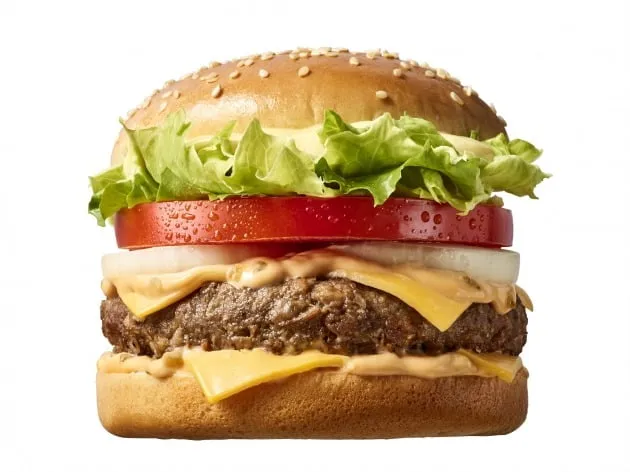

In [ ]:
import requests  # 외부 URL에서 데이터를 가져오기 위한 requests 라이브러리

# requests.get으로 이미지 URL에서 데이터를 스트리밍 방식으로 가져옴
# 가져온 데이터를 이미지 파일로 열고, RGB 모드로 변환
test_img = Image.open(requests.get("https://i.ibb.co/7Ksr5mw/yNp6qTS.png", stream=True).raw).convert("RGB")

# requests.get: 주어진 URL에서 이미지를 가져오고, stream=True 옵션을 사용해 데이터를 스트리밍 방식으로 다운로드합니다.
# Image.open(): PIL 라이브러리의 Image 모듈을 사용해 URL에서 받은 이미지를 열고, .raw 속성으로 이미지를 가져옵니다.
# .convert("RGB"): 이미지를 RGB 모드로 변환하여 다루기 쉽게 만듭니다. 이는 3개의 색상 채널(Red, Green, Blue)을 사용하는 이미지로 변환하는 과정입니다.


# test_img 객체 출력 (이미지를 시각적으로 표시하거나 확인)
test_img

#### 6-2) 햄버거 이미지 벡터화

In [ ]:
test_img_tensor = feature_extractor(images=test_img, return_tensors="pt").to("cuda")
test_outputs = model(**test_img_tensor)

test_embedding = test_outputs.pooler_output.detach().cpu().numpy().squeeze().tolist()

len(test_embedding)

384

#### 6-3) 햄버거 이미지에 대해 DB에 쿼리 날려보기

In [ ]:
query_result = collection.query(   # collection 객체에서 쿼리를 수행하여 유사한 항목을 검색
    query_embeddings=[test_embedding],  # 검색할 때 사용할 임베딩 (test_embedding) 리스트
    n_results=3,  # 유사한 결과를 3개까지 반환하도록 설정
)

# 검색 결과 출력
query_result

{'ids': [['8', '2', '6']],
 'distances': [[146.01182556152344, 222.7047576904297, 276.500244140625]],
 'metadatas': [[{'name': 'Bread', 'uri': 'test/Bread/8.jpg'},
   {'name': 'Bread', 'uri': 'test/Bread/2.jpg'},
   {'name': 'Bread', 'uri': 'test/Bread/6.jpg'}]],
 'embeddings': None,
 'documents': [[None, None, None]],
 'uris': None,
 'data': None,
 'included': ['metadatas', 'documents', 'distances']}

##### 코드 설명

###### 요약
이 코드는 임베딩을 기준으로 벡터 검색을 수행하며, `test_embedding`과 가장 유사한 3개의 항목을 `query_result`에 반환합니다.

###### 1. `collection.query`
이 함수는 주어진 임베딩(`test_embedding`)을 기반으로, 가장 유사한 데이터를 `collection`에서 검색하는 역할을 합니다. 보통 이러한 `collection`은 벡터 데이터베이스나 검색 엔진을 사용하여 유사도를 계산합니다.

###### 2. `query_embeddings`
비교할 임베딩을 리스트 형태로 전달합니다. 여기서는 하나의 `test_embedding`을 기준으로 검색을 수행합니다.

###### 3. `n_results`
검색 결과로 반환할 최대 항목의 수를 지정합니다. 이 코드에서는 3개의 유사한 결과를 반환하도록 설정되어 있습니다.

###### 4. `query_result`
검색 결과가 저장되는 변수입니다. 검색된 항목들은 리스트 또는 딕셔너리 형태로 반환되며, 유사한 데이터에 대한 정보가 포함됩니다.

#### 6-4) 결과물 알아보기 (이미지 출력)

##### 이 코드는 `query_result`에서 반환된 메타데이터를 기반으로, 가장 유사한 세 개의 이미지를 matplotlib을 통해 시각화합니다. 각 이미지에는 해당 이미지의 이름과 유사도를 표시하고, 축은 숨겨서 이미지를 깔끔하게 표시합니다.

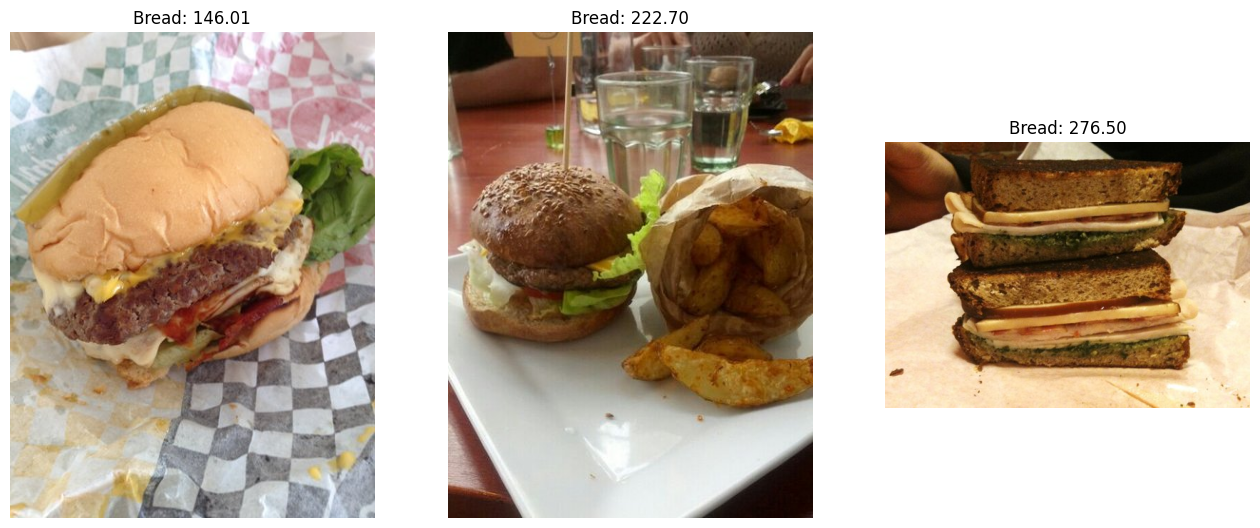

In [ ]:
import matplotlib.pyplot as plt

# 1. 1행 3열의 서브플롯을 생성하고, 그래프 크기는 16x10으로 지정
fig, axes = plt.subplots(1, 3, figsize=(16, 10))

# 2. query_result의 메타데이터를 반복하여 처리
for i, metadata in enumerate(query_result["metadatas"][0]):
    # 3. 해당 메타데이터와 기준 임베딩 간의 거리 계산
    distance = query_result["distances"][0][i]

    # 4. 메타데이터의 이미지 URI를 불러와서 서브플롯에 표시
    axes[i].imshow(Image.open(metadata["uri"]))

    # 5. 이미지 제목을 이미지 이름과 유사도 거리로 설정, 소수점 둘째 자리까지 표시
    axes[i].set_title(f"{metadata['name']}: {distance:.2f}")

    # 6. 이미지의 축을 숨겨서 깔끔하게 출력
    axes[i].axis("off")

### 7단계. 테스트를 위한 쿼리 함수화

##### 코드 요약
이 함수는 주어진 이미지 URL을 받아 해당 이미지를 기반으로 벡터 검색을 수행한 후, 가장 유사한 이미지들을 시각적으로 출력하는 역할을 합니다.


In [ ]:
def query(img_url, n_results=3):
    # 1. 이미지 URL로부터 이미지를 불러오고, RGB로 변환
    test_img = Image.open(requests.get(img_url, stream=True).raw).convert("RGB")

    # 2. 이미지에서 특징을 추출하고, 텐서 형식으로 변환한 후 GPU로 이동
    test_img_tensor = feature_extractor(images=test_img, return_tensors="pt").to("cuda")

    # 3. 모델을 통해 이미지의 임베딩을 생성
    test_outputs = model(**test_img_tensor)

    # 4. 임베딩을 numpy 배열로 변환한 후 리스트로 변환
    test_embedding = test_outputs.pooler_output.detach().cpu().numpy().squeeze().tolist()

    # 5. 생성한 임베딩을 기반으로 벡터 검색을 수행하여 n_results개의 결과를 반환
    query_result = collection.query(
        query_embeddings=[test_embedding],
        n_results=n_results,
    )

    # 6. 결과 시각화를 위해 1행 4열의 서브플롯을 생성
    fig, axes = plt.subplots(1, 4, figsize=(16, 10))

    # 7. 첫 번째 서브플롯에 원본 이미지를 표시
    axes[0].imshow(test_img)
    axes[0].set_title("Query")  # 원본 이미지에 'Query' 제목 설정
    axes[0].axis("off")  # 축을 숨김

    # 8. 검색된 결과 이미지를 순차적으로 서브플롯에 표시
    for i, metadata in enumerate(query_result["metadatas"][0]):
        distance = query_result["distances"][0][i]  # 유사도 거리 계산

        # 9. 검색된 이미지와 유사도 거리 정보를 각각의 서브플롯에 표시
        axes[i+1].imshow(Image.open(metadata["uri"]))
        axes[i+1].set_title(f"{metadata['name']}: {distance:.2f}")  # 이미지 제목에 이름과 거리 표시
        axes[i+1].axis("off")  # 축을 숨김

    return query_result  # 검색 결과 반환

#### 7-1) 다양한 이미지 활용 테스트 실행

{'ids': [['54', '47', '107']],
 'distances': [[291.7901611328125, 295.75018310546875, 302.4823303222656]],
 'metadatas': [[{'name': 'Meat', 'uri': 'test/Meat/4.jpg'},
   {'name': 'Fried food', 'uri': 'test/Fried food/7.jpg'},
   {'name': 'Vegetable-Fruit', 'uri': 'test/Vegetable-Fruit/7.jpg'}]],
 'embeddings': None,
 'documents': [[None, None, None]],
 'uris': None,
 'data': None,
 'included': ['metadatas', 'documents', 'distances']}

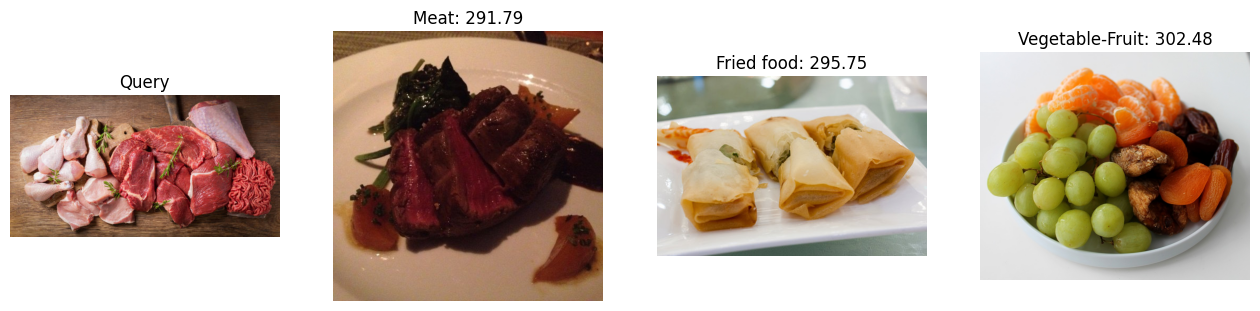

In [ ]:
query("https://i.ibb.co/JmpXmvx/QCado9g.jpg")

{'ids': [['13', '18', '36']],
 'distances': [[237.90960693359375, 259.962646484375, 260.4793395996094]],
 'metadatas': [[{'name': 'Dairy product', 'uri': 'test/Dairy product/3.jpg'},
   {'name': 'Dairy product', 'uri': 'test/Dairy product/8.jpg'},
   {'name': 'Egg', 'uri': 'test/Egg/6.jpg'}]],
 'embeddings': None,
 'documents': [[None, None, None]],
 'uris': None,
 'data': None,
 'included': ['metadatas', 'documents', 'distances']}

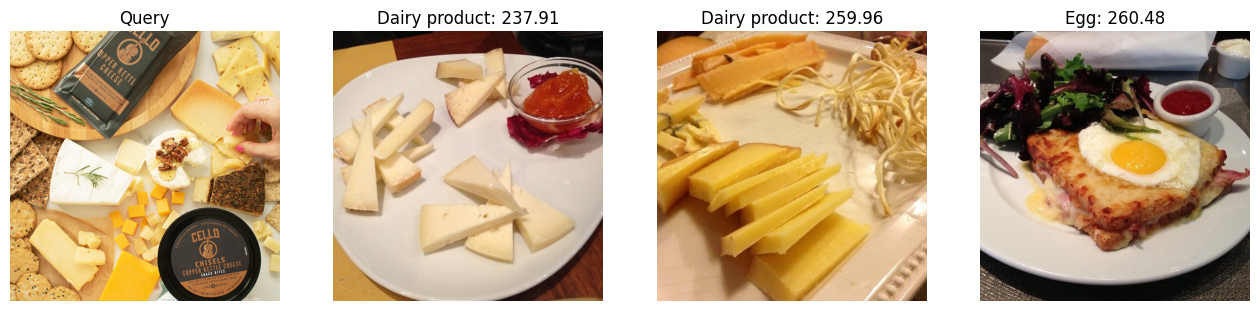

In [ ]:
query("https://i.ibb.co/X5dkHGF/lf5C0LI.png")

# 메타데이터(Metadata)란?

**메타데이터**는 데이터를 설명하는 추가적인 정보를 의미합니다. 쉽게 말해, 데이터 자체의 속성이나 구조, 그 데이터에 대한 부가 정보를 나타내는 데이터입니다.

## 예시: 사진 파일의 메타데이터
사진 파일에 대한 메타데이터는 그 사진의 내용이 아닌, 사진에 대한 정보를 포함합니다. 예를 들어:

- **촬영 날짜와 시간**
- **사진의 해상도**
- **파일 형식** (예: .jpg, .png)
- **GPS 정보** (촬영 위치)
- **카메라 모델과 설정 값** (ISO, 노출 시간 등)

## 메타데이터의 목적
메타데이터의 주요 목적은 데이터를 더 잘 이해하고 조직하기 위해 데이터를 설명하는 정보를 제공하는 것입니다.


## 메타데이터의 사용 예시

### 1. 검색
메타데이터가 있으면 파일이나 정보를 더 쉽게 검색하고 분류할 수 있습니다. 예를 들어, 특정 클래스의 이미지를 찾거나, 경로를 통해 이미지를 분류할 수 있습니다.

### 2. 분석
데이터 분석을 할 때, 메타데이터를 기반으로 특정 범주별로 데이터를 구분할 수 있습니다. 이를 통해 데이터의 속성을 더 깊이 이해하고, 분석을 체계적으로 수행할 수 있습니다.
